In [4]:
#import libraries necessary
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
#camera calibration
#read image
imgpoints = [] #blank array
objpoints = []
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
for name in glob.glob('camera_cal/calibration*'):
    objp = np.zeros((nx*ny,3), np.float32) 
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # object points
    img = mpimg.imread(name)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert to gray
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) # find corners
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret) #draw corners
        objpoints.append(objp)
        imgpoints.append(corners)
        #calibrate and undistort
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undst = cv2.undistort(img, mtx, dist, None, mtx)


    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(undst)
    #ax2.set_title('Undistorted Image', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0)

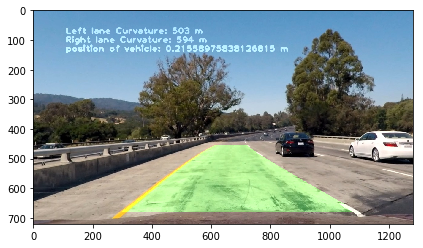

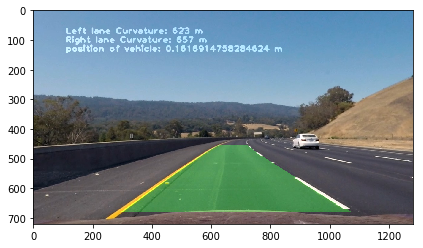

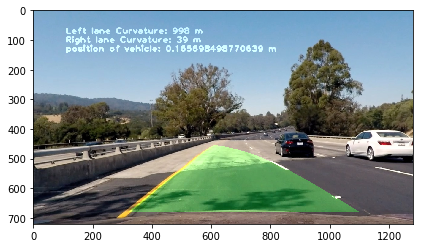

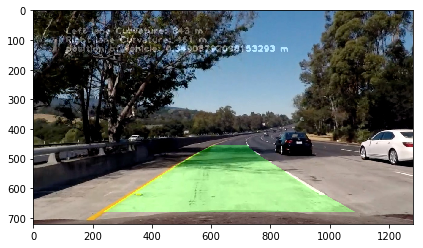

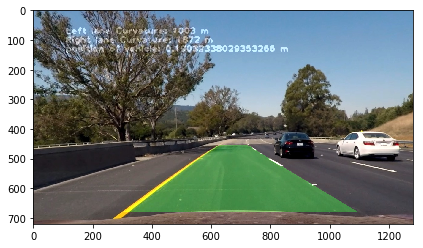

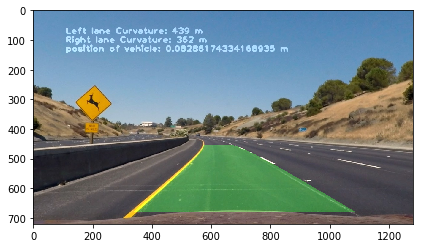

In [25]:
#final images for pictures.
#for car in glob.glob('project_video.mp4'):
for car in glob.glob('test_images/test*'):
    s_thresh=(170, 255) # adjust for s channel
    sx_thresh=(20, 120) # adjust for gray  
    #HLS convert
    img = mpimg.imread(car)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undst,cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(undst,cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    #plt.imshow(h_channel)
    #sobel
    
    sobelx =cv2.Sobel(gray, cv2.CV_64F,1,0)
    abs_sobelx = np.absolute(sobelx)
    scaled = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #threshold
    
    sxbinary = np.zeros_like(scaled)
    sxbinary[(scaled>=sx_thresh[0]) &(scaled<=sx_thresh[1])] = 1
    
    # s channel
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #f, ax1 = plt.subplots(1)
    #f.tight_layout()
    #ax1.imshow(combined_binary, cmap='gray')

    
    #perspective transform
    src = np.float32([[555,455],[725,455],[1280,680],[0,680]])
    dst = np.float32([[0,0],[combined_binary.shape[1],0],[combined_binary.shape[1],combined_binary.shape[0]],[0,combined_binary.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1],combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
    #print(combined_binary.shape[0])
    #f, ax2 = plt.subplots(1)
    #f.tight_layout()
    #ax2.imshow(warped)

    #2nd order polynomial
    #histogram
    bottom_half = warped[warped.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #f, ax2 = plt.subplots(1)
    #f.tight_layout()
    #plt.plot(histogram)
    
    #hyperparameters
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    window_height = np.int(warped.shape[0]//nwindows)
    #get nonzero values
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #update current position
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    #array 
    left_lane_inds = []
    right_lane_inds = []
    #empty image
    out_img = np.dstack((warped, warped, warped))
    #going through the windows 
    for window in range(nwindows):
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin  
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
               
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    #polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


    #better visualization 
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #f, ax2 = plt.subplots(1)
    #f.tight_layout()
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.imshow(result)
    
    #radius of curvature in pixels 
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print("the left and right radius of curvature in pixels for",car," respectively ",left_curverad,"&", right_curverad)
    
    #radius of curvature in meters 
    # 30 and 3.7 defined as per street regulations
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    Left = "Left lane Curvature: " + str(int(left_curverad)) + " m"
    Right = "Right lane Curvature: " + str(int(right_curverad))+ " m"
    fontScale=2
    thickness=3
    fontFace = cv2.FONT_HERSHEY_PLAIN
    #print("the left and right radius of curvature in meters for",car," respectively ",left_curverad,"&", right_curverad)
    
    #car location #looking for offset from midpoint of lane to center of image 
    x_center = combined_binary.shape[0]/2
    x_center_m = (((right_fitx[719] - left_fitx[719])/2) - x_center) * xm_per_pix
    dist_cam = "position of vehicle: " + str(float(x_center_m)) + " m"
    #print("offset in m", y_center_m)
    #place object on road 
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    cv2.putText(newwarp, Left, (110,80), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, Right, (110,110), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, dist_cam, (110,140), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    # Combine the result with the original image
    f, ax2 = plt.subplots(1)
    f.tight_layout()
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    plt.imshow(result)

In [11]:
#functions
def process_image(image):
    s_thresh=(170, 255) # adjust for s channel
    sx_thresh=(20, 100) # adjust for gray  
    #HLS convert
    img = image
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undst,cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(undst,cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    #plt.imshow(h_channel)
    #sobel
    
    sobelx =cv2.Sobel(gray, cv2.CV_64F,1,0)
    abs_sobelx = np.absolute(sobelx)
    scaled = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #threshold
    
    sxbinary = np.zeros_like(scaled)
    sxbinary[(scaled>=sx_thresh[0]) &(scaled<=sx_thresh[1])] = 1
    
    # s channel
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #f, ax1 = plt.subplots(1)
    #f.tight_layout()
    #ax1.imshow(combined_binary, cmap='gray')

    
    #perspective transform
    src = np.float32([[555,455],[725,455],[1280,680],[0,680]])
    dst = np.float32([[0,0],[combined_binary.shape[1],0],[combined_binary.shape[1],combined_binary.shape[0]],[0,combined_binary.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1],combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
    #f, ax2 = plt.subplots(1)
    #f.tight_layout()
    #ax2.imshow(warped)

    #2nd order polynomial
    #histogram
    bottom_half = warped[warped.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #hyperparameters
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    window_height = np.int(warped.shape[0]//nwindows)
    #get nonzero values
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #update current position
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    #array 
    left_lane_inds = []
    right_lane_inds = []
    #empty image
    out_img = np.dstack((warped, warped, warped))
    #going through the windows 
    for window in range(nwindows):
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin  
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
               
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    #polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


    #better visualization 
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #f, ax2 = plt.subplots(1)
    #f.tight_layout()
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.imshow(result)
    
    #radius of curvature in pixels 
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print("the left and right radius of curvature in pixels for",car," respectively ",left_curverad,"&", right_curverad)
    
    #radius of curvature in meters 
    # 30 and 3.7 defined as per street regulations
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Creating Text and set font parameters
    Left = "Left lane Curvature: " + str(int(left_curverad)) + " m"
    Right = "Right lane Curvature: " + str(int(right_curverad))+ " m"
    fontScale=1
    thickness=2
    fontFace = cv2.FONT_HERSHEY_PLAIN

    #print("the left and right radius of curvature in meters for",car," respectively ",left_curverad,"&", right_curverad)
    
    #car location #looking for offset from midpoint of lane to center of image 
    x_center = combined_binary.shape[0]/2
    x_center_m = (((right_fitx[719] - left_fitx[719])/2) - x_center) * xm_per_pix
    dist_cam = "position of vehicle: " + str(float(x_center_m)) + " m"
    #print("offset in m", y_center_m)
    
    #place object on road 
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    cv2.putText(newwarp, Left, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, Right, (110,110), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, dist_cam, (110,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    # Combine the result with the original image
    #f, ax2 = plt.subplots(1)
    #f.tight_layout()
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result
    

In [8]:
video_name_ori = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4")
frame_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time frame_clip.write_videofile(video_name_ori, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:13<00:00,  4.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 8s, sys: 3.12 s, total: 2min 11s
Wall time: 4min 16s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_name_ori))